# Exercise 09 - Topology optimization for continua


## Task 1 - Book shelf

Let us consider a bookshelf that needs a support structure. The design domain is given by a unit square $x \in [0, 1]^2$ and a maximum thickness $d_{max}=0.1$. The left boundary of the domain $\partial \Omega_D$ is fixed to the wall and the top boundary $\partial \Omega_N$ is loaded with a uniform line load representing the weight of books.

![Four bar truss](https://meyer-nils.github.io/structural_optimization/figures/domain.png)


In [10]:
import matplotlib.pyplot as plt
import torch
from torchfem import Planar
from torchfem.materials import IsotropicPlaneStress
from tqdm import tqdm

torch.set_default_dtype(torch.double)

This is the planar FEM model from last exercise with an increased number of elements per direction $N=30$.

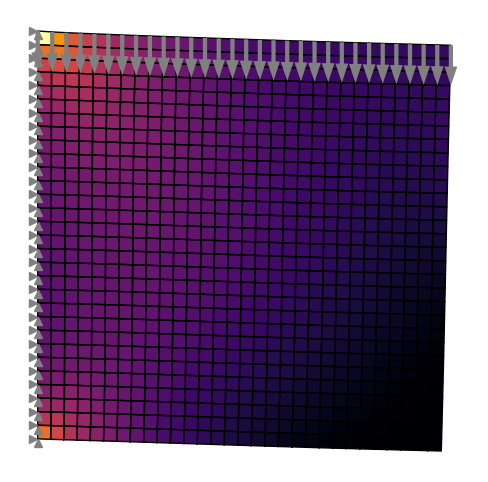

In [11]:
# Define Material
material = IsotropicPlaneStress(E=1000.0, nu=0.3)

# Create nodes
N = 30
n1 = torch.linspace(0.0, 1, N + 1)
n2 = torch.linspace(0.0, 1, N + 1)
n1, n2 = torch.stack(torch.meshgrid(n1, n2, indexing="xy"))
nodes = torch.stack([n1.ravel(), n2.ravel()], dim=1)

# Create elements connecting nodes
elements = []
for j in range(N):
    for i in range(N):
        n0 = i + j * (N + 1)
        elements.append([n0, n0 + 1, n0 + N + 2, n0 + N + 1])
elements = torch.tensor(elements)

# Define masks for boundary conditions
top = nodes[:, 1] == 1.0
left = nodes[:, 0] == 0.0
right = nodes[:, 0] == 1.0
tip = top & right

# Load at top
forces = torch.zeros_like(nodes)
forces[top, 1] = -1.0 / N
forces[tip, 1] = -0.5 / N

# Constrained displacement at left end
displacements = torch.zeros_like(nodes)
constraints = torch.zeros_like(nodes, dtype=bool)
constraints[left, :] = True

# Thickness
d = 0.1
thickness = d * torch.ones(len(elements))

# Create and plot the domain
square = Planar(
    nodes, elements, forces, displacements, constraints, thickness, C=material.C()
)

# Solve the system
u, f = square.solve()

# Compute von Mises stress
mises = square.compute_stress(u, mises=True)

# Plot the result
square.plot(u=u, element_property=mises, cmap="inferno")

In addition, you are provided with a function that performs root finding with the bisection method and the computation of element surface areas from previous exercises.

In [12]:
def bisection(f, a, b, max_iter=50, tol=1e-12):
    # Bisection method always finds a root, even with highly non-linear grad
    i = 0
    while (b - a) > tol:
        c = (a + b) / 2.0
        if i > max_iter:
            raise Exception(f"Bisection did not converge in {max_iter} iterations.")
        if f(a) * f(c) > 0:
            a = c
        else:
            b = c
        i += 1
    return c

In [13]:
def compute_areas(truss):
    areas = torch.zeros((truss.n_elem))
    nodes = truss.nodes[truss.elements, :]
    for w, q in zip(truss.etype.iweights(), truss.etype.ipoints()):
        J = truss.etype.B(q) @ nodes
        detJ = torch.linalg.det(J)
        areas[:] += w * detJ
    return areas

To save material, the bookshelf should use only 40% of the given design space, while being as stiff as possible to support many books without bending. We want to achieve this by topology optimization of the component. 

To do so, we implement a topology optimization algorithm with *optimality conditions* in a function named `optimize(fem, rho_0, rho_min, rho_max, V_0, iter=100, xi=0.5, m=0.2, p=1.0, r=0.0)` that takes the FEM model `fem`, the initial density distribution `rho_0`, the minimum and maximum thickness distributions `rho_min, rho_max`, the volume constraint, the maximum iteration count `iter` with a default value of 100, a SIMP penalty factor `p` with default 1, and a radius for sensitivity filtering `r` with a default 0.0.

a) Check if there is a feasible solution, i.e. if the design with minimum density has a volume smaller than the volume constraint. If not, raise an exception. *Hint*: You can compute the volume as the inner product of `rho_min` and the element volumes. 

b) The filter weights can be precomputed before the optimization loop. Implement the computation of the filter weights if the radius is greater than 0.
*Hints*: Start by computing the center of each element and store it in a tensor of shape `(Mx2)` for M elements. Then, compute the distance between each element center using the function `torch.cdist()` and store it in a tensor of shape `(MxM)`. Finally, compute the filter weights using the formula $H_{ij} = \max(0, r - d_{ij})$.

c) Add code that modifies the thickness according to the current design variables and solves the FEM problem in each iteration. 
*Hints*: You can overwrite `fem.thickness` to set the thickness of the FEM object. You can use the thickness variable to inject the material density into the stiffness calculation and account for the penalty factor in the compliance calculation. 

d) Compute the sensitivity of the compliance with respect to the design variables. *Hints*: This is equivalent to the compliance sensitivity in the previous exercise, but you need to account for the penalty factor. 

e) Filter the sensitivity using the filter weights if the radius is greater than 0.

f) Define a function `make_step(mu)` that computes the design variable update for a given Lagrange parameter `mu`. *Hints*: Use the formula from the optimality conditions and clamp the result with the move limits. 

g) Define a function `g(mu)` that evaluates the volume constraint. *Hints*: Use the `make_step` function to compute the design variable update and return the volume constraint violation.

h) Use the bisection method to find the Lagrange parameter that satisfies the volume constraint.

In [14]:
def optimize(fem, rho_0, rho_min, rho_max, V_0, iter=100, xi=0.5, m=0.2, p=1.0, r=0.0):
    k0 = torch.einsum("i,ijk->ijk", 1.0 / fem.thickness, fem.k())
    rho = [rho_0]
    vols = d * compute_areas(fem)

    # Check if there is a feasible solution before starting iteration
    if torch.inner(rho_min, vols) > V_0:
        raise Exception("rho_min is not compatible with V_0.")

    # Precompute filter weights
    if r > 0.0:
        ecenters = torch.stack([torch.mean(fem.nodes[e], dim=0) for e in fem.elements])
        dist = torch.cdist(ecenters, ecenters)
        H = r - dist
        H[dist > r] = 0.0

    # Iterate solutions
    for k in tqdm(range(iter)):
        # Adjust thickness variables
        fem.thickness = d * rho[k] ** p

        # Compute solution
        u_k, f_k = fem.solve()

        # Compute sensitivities
        disp = u_k[fem.elements, :].reshape(fem.n_elem, -1)
        w_k = 0.5 * torch.einsum("...i,...ij,...j", disp, k0, disp)
        sensitivity = -p * d * rho[k] ** (p - 1) * 2.0 * w_k

        # Filter sensitivities (if r provided)
        if r > 0.0:
            sensitivity = H @ (rho[k] * sensitivity) / H.sum(dim=0) / rho[k]

        # For a certain value of mu, apply the iteration scheme
        def make_step(mu):
            G_k = -sensitivity / (mu * vols)
            upper = torch.min(rho_max, (1 + m) * rho[k])
            lower = torch.max(rho_min, (1 - m) * rho[k])
            rho_trial = G_k**xi * rho[k]
            return torch.clamp(rho_trial, lower, upper)

        # Constraint function
        def g(mu):
            rho_k = make_step(mu)
            return torch.dot(rho_k, vols) - V_0

        # Find the root of g(mu)
        mu = bisection(g, 1e-10, 100.0)

        rho.append(make_step(mu))

    return rho

i) Set up the initial design variables $\rho_0=0.5, \rho_{min}=0.01, \rho_{max}=1.0$ and a volume constraint $V_0= 0.5 V_{max}$ with the maximum design volume $V_{max}$. 

In [15]:
# Initial thickness, minimum thickness, maximum thickness
rho_0 = 0.5 * torch.ones(len(square.elements))
rho_min = 0.01 * torch.ones_like(rho_0)
rho_max = 1.0 * torch.ones_like(rho_0)

# Initial volume (40% of maximum design volume)
vols = d * compute_areas(square)
V0 = 0.4 * vols.sum()

j) Perform the optimization with the following parameters: 
$$p=3$$
$$r=0$$ 

100%|██████████| 100/100 [00:02<00:00, 47.23it/s]


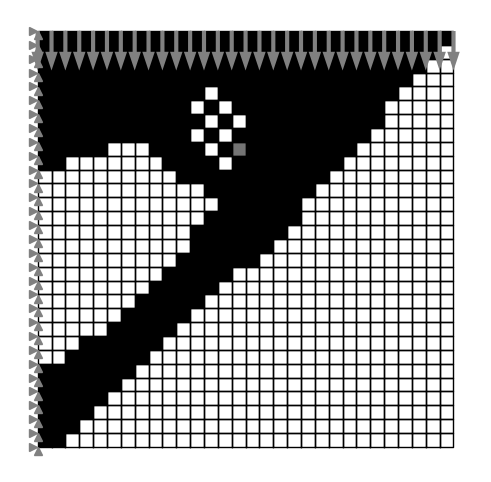

In [16]:
# Optimize and visualize results
d_opt = optimize(square, rho_0, rho_min, rho_max, V0, p=3.0, r=0.0)
square.plot(element_property=d_opt[-1], cmap="gray_r")

k) Plot the evolution of design variables vs. iterations. What does the graph tell you?

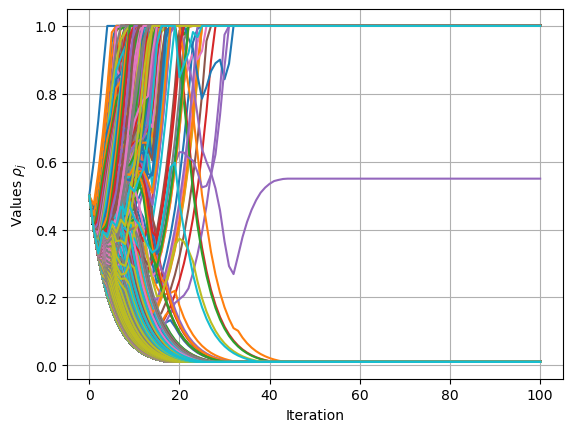

In [17]:
plt.plot(torch.stack(d_opt).detach())
plt.xlabel("Iteration")
plt.ylabel("Values $ρ_j$")
plt.grid()

*The graph shows that the design variables converge to 0 or 1 within the specified number of iterations, which is expected for the SIMP method.*

l) Perform the optimization with 100 iterations and the following parameters
$$p=3$$
$$r=0.05$$ 

100%|██████████| 100/100 [00:02<00:00, 42.36it/s]


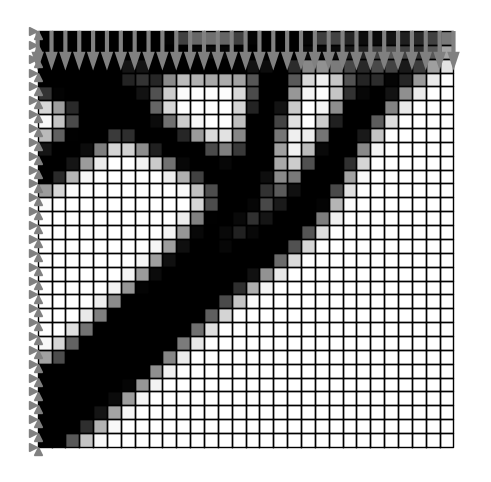

In [18]:
# Optimize and visualize results
d_opt = optimize(square, rho_0, rho_min, rho_max, V0, p=3.0, r=0.05)
square.plot(element_property=d_opt[-1], cmap="gray_r")

m) How do you interpret the design? Decide which manufacturing process you would like to use and use a CAD software to create a design based on your optimization.